<a href="https://colab.research.google.com/github/TAUforPython/machinelearning/blob/for-example-and-testing/KuramotoTests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kuramoto Tests

In [1]:
import numpy as np
import matplotlib.pylab as plt
import networkx as nx

In [3]:
# Copyright (c) 2014, Warren Weckesser
# All rights reserved.
# See the LICENSE file for license information.

'''
LICENSE
Copyright (c) 2014, Warren Weckesser
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the {organization} nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.
'''

import numpy as np
from scipy.integrate import odeint


# Tuple holding the major and minor versions of numpy.
_NUMPY_VERSION = tuple(int(d) for d in np.__version__.split('.')[:2])

if _NUMPY_VERSION >= (1, 7):
    _astype_kwargs = {'copy': False}
else:
    _astype_kwargs = {}


def _check_args(kwargs):
    """
    Check for arguments that are not supported with array differential
    equations.
    """
    _unsupported_odeint_args = ['col_deriv', 'ml', 'mu']
    bad_args = [arg for arg in kwargs if arg in _unsupported_odeint_args]
    if len(bad_args) > 0:
        raise ValueError("The odeint argument %r is not supported by "
                         "odeintw for array differential equations." %
                         (bad_args[0],))


def _complex_to_real_jac(jac):
    """
    Convert a complex array to a real array with doubled dimensions.
    Each element a+i*b of `jac` is expanded to the 2x2 real block:
        [[a, -b],
         [b,  a]].
    For example, the 2x2 complex matrix::
        [1+2j  3+4j]
        [5+6j  7+8j]
    becomes the real matrix::
        [1 -2  3 -4]
        [2  1  4  3]
        [5 -6  7 -8]
        [6  5  8  7]
    """
    real_jac = np.empty((2*jac.shape[0], 2*jac.shape[1]))
    real_jac[::2,   ::2] = jac.real
    real_jac[1::2, 1::2] = jac.real
    real_jac[::2,  1::2] = -jac.imag
    real_jac[1::2,  ::2] = jac.imag
    return real_jac


def _transform_banded_jac(bjac):
    """
    Convert a real matrix of the form (for example)
        [0 0 A B]        [0 0 0 B]
        [0 0 C D]        [0 0 A D]
        [E F G H]   to   [0 F C H]
        [I J K L]        [E J G L]
                         [I 0 K 0]
    That is, every other column is shifted up one.
    """
    # Shift every other column.
    newjac = np.zeros((bjac.shape[0] + 1, bjac.shape[1]))
    newjac[1:,::2] = bjac[:, ::2]
    newjac[:-1, 1::2] = bjac[:, 1::2]
    return newjac


def odeintw(func, y0, t, **kwargs):
    """
    An odeint-like function for complex array-valued differential equations.
    The function `scipy.integrate.odeint` is a wrapper of the LSODA function
    for solving ordinary differential equations.  It is designed to handle
    a system of first order differential equations expressed as a vector
    function.  `odeint` does not handle equations with complex dependent
    variables, or array equations.
    `odeintw` is a wrapper of `odeint` that adds the ability to handle
    complex and array differential equations.  See the docstring of odeint
    for an explanation of its arguments.
    Unlike odeint, all arguments after the first three position arguments
    `func` (the system definition function), `y0` (the initial condition)
    and `t` (the time values) must be given as keyword arguments.
    Initial conditions
    ------------------
    The initial condition `y0` given to `odeintw` determines the type of the
    solution that is generated.  The data type and shape of the value
    returned by `func` must match those of the initial condition.
    If the solution is to be complex, the initial condition must be complex.
    To solve a complex differential equation with real initial conditions,
    give complex initial conditions with zero imaginary parts.
    Similarly, the shape of the solution of a matrix differential equation
    is determined by the shape of the initial condition.  For example, if
    the initial condition has shape (2,3), then `func` must return a numpy
    array (or something array-like) that has shape (2,3).
    Special handling of Jacobian arguments
    --------------------------------------
    The argument `Dfun` may be used with array equations.  If `shp` is the
    shape of the array, then the shape of the Jacobian array returned by
    `Dfun` must be ``shp + shp``.  For example, if the array is 2-d `F`,
        jac[m, n, i, j] holds dF[m,n]/da[i,j]
    `Dfun` may also be used with complex equations.  However, if the
    functions computed by `func` are not complex differentiable, the
    Jacobian function should not be used.  To use the Jacobian argument in
    this case, the equations should be rewritten as a system of real
    equations for the real and imaginary parts of the solution.  For
    example, the conjugation operation is not complex differentiable, so
    to use an explicit Jacobian for the complex scalar equation
        dz/dt = z.conj(),
    the equation must be written as
        dx/dt = x
        dy/dt = -y
    Then the Jacobian of the real system is [[1, 0], [0, -1]].
    If `Dfun` is not given as an argument, the system may be left as a
    complex differential equation.
    In the case of arrays with dimension 2 or more, the odeint arguments
    `col_deriv`, `ml` and `mu` can not be used.
    Complex array equations are handled, but to use `Dfun`, the same
    requirement on the complex differentiability of the components
    holds.
    """

    full_output = kwargs.get('full_output', False)
    Dfun = kwargs.pop('Dfun', None)

    y0 = np.atleast_1d(y0)
    shape = y0.shape

    if y0.ndim == 1:
        func1 = func
        jacfunc1 = Dfun
    else:
        # y0 has dimension greater than 1.
        _check_args(kwargs)

        # Flatten y0, and create a wrapper for func that can be used
        # by odeint.
        y0 = y0.ravel()

        def vecfunc(y, t, *args):
            a = y.reshape(shape)
            dadt = func(a, t, *args)
            return np.asarray(dadt).ravel()

        func1 = vecfunc

        if Dfun is not None:

            def jacfunc(y, t, *args):
                a = y.reshape(shape)
                jac = Dfun(a, t, *args)
                return np.asarray(jac).reshape(y0.size, y0.size)

            jacfunc1 = jacfunc
        else:
            jacfunc1 = None

    if not np.iscomplexobj(y0):
        y0 = y0.astype(np.float64, **_astype_kwargs)
        func2 = func1
        jacfunc2 = jacfunc1
    else:
        # y0 is complex.
        col_deriv = kwargs.pop('col_deriv', False)
        ml = kwargs.pop('ml', None)
        mu = kwargs.pop('mu', None)
        kwargs['ml'] = None if ml is None else 1 + 2*ml
        kwargs['mu'] = None if mu is None else 1 + 2*mu

        # Cast y0 to np.complex128.
        y0 = y0.astype(np.complex128, **_astype_kwargs)

        # realfunc is a wrapper of the user's function that can be
        # used by odeint.
        def realfunc(y, t, *args):
            z = y.view(np.complex128)
            dzdt = func1(z, t, *args)
            # func might return a python list, so convert its return
            # value to an array with type np.complex128, and then return
            # a np.float64 view of that array.
            dydt = np.asarray(dzdt, dtype=np.complex128).view(np.float64)
            return dydt

        func2 = realfunc

        if jacfunc1 is not None:

            def jacfuncz(y, t, *args):
                z = y.view(np.complex128)
                jac = jacfunc1(z, t, *args)
                if col_deriv:
                    # If col_deriv is True, transpose the result returned
                    # by jacfunc1, and continue as if col_deriv was False.
                    jac = jac.T
                # Convert jac to real_jac, an array in which each complex value
                # a + i*b in jac is expanded to the 2x2 array [[a, -b], [b, a]].
                real_jac = _complex_to_real_jac(jac)
                if ml is not None or mu is not None:
                    # Banded; shift every other column up one.
                    real_jac = _transform_banded_jac(real_jac)
                return real_jac

            jacfunc2 = jacfuncz
        else:
            jacfunc2 = None

    # Call scipy.integrate.odeint with our wrapper.
    result = odeint(func2, y0.view(np.float64), t, Dfun=jacfunc2, **kwargs)

    if full_output:
        sol, infodict = result
    else:
        sol = result

    if np.iscomplexobj(y0):
        # Restore the complex view.
        sol = sol.view(np.complex128)

    # Restore the shape.
    sol = sol.reshape(-1, *shape)

    if full_output:
        result = (sol, infodict)
    else:
        result = sol
    return result

In [4]:
"""
NetworkClasses
@author: JoyClimaco
"""

import numpy as np
from scipy.integrate import odeint

class StuartLandau(object):

    """ Class defining a Stuart-Landau network object.
        Holds the most important network properties of a network formed by N Stuart-Landau
        oscillators, as well as its corresponding ODE system and time integration functions.

        Attributes
        ----------
        w : ndarray of shape (N)
            Natural frequency of each oscillator
        A : matrix (nparray) of shape (N,N)
            Adjacency matrix
        K : float
            Coupling parameter
        alpha: float
            Stuart-Landau limit cycle parameter
        F : ndarray of shape (N)
            Magnitude of external force for each oscillator
        Omega : float
            Frequency of the external force
        systype : string ('complex', 'rectangular', 'polar')
            Coordinates used in the Stuart-Landau ODE system
    """

    def __init__(self, w, A, K, alpha, F=None, Omega=0, systype='rectangular'):

        self.type = 'StuartLandau'                     # Network type
        self.w = w                                     # Natural frequencies
        self.A = A                                     # Adjacency matrix
        self.alpha = alpha                             # SL limit cycle parameter
        self.K = K                                     # Coupling constant
        self.F = F                                     # Force strength
        self.Omega = Omega                             # Frenquency of force
        self.systype = systype                         # System type

        # Describes the coupling distribution
        self.dist = {'type' : None,
                    'shape' : None,
                    'scale' : None,
                    'loc' : None,
                    'mean' : None,
                    'std' : None}

    @property
    def N(self): # Number of oscillators
        return np.size(self.w)

    @property
    def edges(self): # indexes of the network edges
        return np.transpose(np.nonzero(self.A))

    @property
    def Ne(self): # Number of edges
        return np.size(self.edges,0)

    @property
    def forced_osc(self): # Forced oscillators' indexes
        return np.nonzero(self.F)

    @property
    def f(self): # Fraction of forced oscillators
        return np.size(self.forced_osc)/self.N

    def __call__(self, z, t=0):

        """ Makes the StuartLandau object a callable function corresponding to the ODE system
        for the oscillators' positions z at time t
        """

        # Complex form of SL system
        if self.systype =='complex':

            # Isolated oscillator terms
            zdot = np.zeros(self.N, dtype='complex')
            for i in range(self.N):
                zdot[i] = (1j*self.w[i] + self.alpha**2 - z[i]*np.conj(z[i])) * z[i]

            # Forced terms
            if self.F is not None:
                for i in self.forced_osc:
                    zdot[i] += self.F[i] * np.exp(1j * self.Omega * t)

            # Coupling
            for k in range(self.Ne):
                [i, j] = self.edges[k]
                zdot[i] += self.K * self.A[i,j] * (z[j] - z[i])

            return zdot

        # SL system in polar coordinates
        if self.systype =='polar':

            z = np.reshape(z, (2,self.N))
            rho = z[0]
            theta = z[1]
            rhodot = np.zeros(self.N)
            thetadot = np.zeros(self.N)

            for i in range(self.N):
                rhodot[i] = (self.alpha**2 - rho[i]**2)*rho[i]
                thetadot[i] = self.w[i]

            if self.F is not None:
                for i in self.forced_osc:
                    rhodot[i] += self.F[i] * np.cos(t*self.Omega - theta[i])
                    thetadot[i] += self.F[i] * np.sin(t*self.Omega - theta[i])

            for k in range(self.Ne):
                [i, j] = self.edges[k]
                rhodot[i] += self.K * self.A[i,j] * (rho[j] * np.cos(theta[j] - theta[i]) - rho[i])
                thetadot[i] += self.K * self.A[i,j] * (rho[j]/rho[i]) * np.sin(theta[j] - theta[i])

            return np.concatenate((rhodot, thetadot))

        # SL system in rectangular coordinates
        if self.systype =='rectangular':

            z = np.reshape(z, (2,self.N))
            x = z[0]
            y = z[1]
            xdot = np.zeros(self.N)
            ydot = np.zeros(self.N)

            for i in range(self.N):
                aux = self.alpha**2 - x[i]**2 - y[i]**2
                xdot[i] = aux*x[i] - self.w[i]*y[i]
                ydot[i] = aux*y[i] + self.w[i]*x[i]

            if self.F is not None:
                for i in self.forced_osc:
                    xdot[i] += self.F[i] * np.cos(t*self.Omega)
                    ydot[i] += self.F[i] * np.sin(t*self.Omega)

            for k in range(self.Ne):
                [i, j] = self.edges[k]
                xdot[i] += self.K * self.A[i,j] * (x[j] - x[i])
                ydot[i] += self.K * self.A[i,j] * (y[j] - y[i])

            return np.concatenate((xdot, ydot))

    def integrate(self, z0, t0, tf=None, dt=0.1):

        """ Class method to calculate the system's time evolution through numerical integration

        Parameters:
        ----------
        z0 : complex ndarray of shape (N)
            State of system at initial time t0
        t0 : float or ndarray
            Initial time (float) or time array on which to evolve the system
        tf : float
            Final time value
        dt : float
            Size of steps in the time interval

        Returns
        ----------
        z : ndarray of shape (N, Nt)
            z[i] gives time evolution array for the ith oscillator
        t : ndarray of shape (Nt)
            Time values for which we evaluated the integral
        """

        if tf==None:
            t = t0
        else:
            t = np.arange(t0,tf,dt)

        # If the system is in its compex form, we use the special numerical integration
        # function odeintw, which extends scipy's odeint to accept complex ODE's
        # Obs: the initial condition z0 must be of type complex for this solver to work
        if self.systype =='complex':

            z = odeintw(self, z0, t).T

        if self.systype =='polar':

            # Jacobian for polar coordinates
            def pJac(z, t=0):

                z = np.reshape(z, (2,self.N))
                rho = z[0]
                theta = z[1]
                jac = np.zeros((2*self.N, 2*self.N))

                # Diagonal terms
                for i in range(self.N):
                    jac[i,i] = self.alpha**2 - 3 * rho[i]**2

                # Forced terms (off-diagonal)
                if self.F is not None:
                    for i in self.forced_osc:
                        jac[i,(i+self.N)] += - self.F[i] * np.sin(t*self.Omega - theta[i])
                        jac[(i+self.N),(i+self.N)] += self.F[i] * np.cos(t*self.Omega - theta[i])

                # Coupling terms (off-diagonal when assuming there are no self-edges)
                for k in range(self.Ne):
                    [i, j] = self.edges[k]
                    jac[i, j] += self.K * self.A[i,j] * np.cos(theta[j] - theta[i])
                    jac[i,(j+self.N)] = - self.K * self.A[i,j] * rho[j] * np.sin(theta[j] - theta[i])
                    jac[(i+self.N),j] = (self.K/rho[i]) * self.A[i,j] * np.sin(theta[j] - theta[i])
                    jac[(i+self.N),(j+self.N)] = self.K * self.A[i,j] * (rho[j]/rho[i]) * np.cos(theta[j] - theta[i])

                return jac

            rho0 = np.absolute(z0)
            theta0 = np.angle(z0)
            z0 = np.concatenate((rho0,theta0), axis=0)

            z = odeint(self, z0, t, Dfun=pJac).T
            rho = z[:self.N]
            theta = z[self.N:]
            z = rho*np.exp(1j*theta)

        if self.systype =='rectangular':

            # Jacobian for rectangular coordinates
            def rJac(z, t=0):

                z = np.reshape(z, (2,self.N))
                x = z[0]
                y = z[1]
                jac = np.zeros((2*self.N, 2*self.N))

                # Individual oscillator dynamics
                for i in range(self.N):
                    jac[i,i] = self.alpha**2 - y[i]**2 - 3*x[i]**2
                    jac[i,(i+self.N)] = - 2*x[i]*y[i] - self.w[i]
                    jac[(i+self.N),i] = - 2*x[i]*y[i] + self.w[i]
                    jac[(i+self.N),(i+self.N)] = self.alpha**2 - x[i]**2 - 3*y[i]**2

                # Coupling terms
                for k in range(self.Ne):
                    [i,j] = self.edges[k]
                    jac[i,j] += self.K*self.A[i,j]
                    jac[i+self.N,j+self.N] += self.K*self.A[i,j]

                return jac

            x0 = np.real(z0)
            y0 = np.imag(z0)
            z0 = np.concatenate((x0,y0), axis=0)

            z = odeint(self, z0, t, Dfun=rJac).T
            x = z[:self.N]
            y = z[self.N:]
            z = x + 1j*y

        return z, t

class KuramotoNetwork(object):

    """ Class defining a Kuramoto network object.
        Holds the most important properties of a network formed by N Kuramoto oscillators,
        as well as its corresponding ODE system and time integration functions.

        Attributes
        ----------
        w : ndarray of shape (N)
            Natural frequency of each oscillator
        A : matrix (nparray) of shape (N,N)
            Adjacency matrix
        K : float
            Coupling parameter
        F : ndarray of shape (N)
            Magnitude of external force for each oscillator
        Omega : float
            Frequency of the external force
    """

    def __init__(self, w, A, K, F=None, Omega=0, rot_frame=False):

        self.type = 'Kuramoto'                         # Network type
        self.w = w                                     # Natural frequencies
        self.A = A                                     # Adjacency matrix
        self.K = K                                     # Coupling constant
        self.F = F                                     # Force strength
        self.Omega = Omega                             # Frenquency of force
        self.rot_frame = rot_frame                     # Defines the phase reference frame

        # Describes the coupling distribution
        self.dist = {'type' : None,
                    'shape' : None,
                    'scale' : None,
                    'loc' : None,
                    'mean' : None,
                    'std' : None}

    @property
    def N(self): # Number of oscillators
        return np.size(self.w)

    @property
    def edges(self): # indexes of the network edges
        return np.transpose(np.nonzero(self.A))

    @property
    def Ne(self): # Number of edges
        return np.size(self.edges,0)

    @property
    def forced_osc(self): # Forced oscillators' indexes
        return np.nonzero(self.F)

    @property
    def f(self): # Fraction of forced oscillators
        return np.size(self.forced_osc)/self.N

    def __call__(self, theta, t=0):

        """ Makes the StuartLandau object a callable function corresponding to the ODE system
        for the oscillators' phases theta at time t
        """

        thetadot = np.zeros(self.N)

        # Individual oscillator dynamics
        for i in range(self.N):
            thetadot[i] += self.w[i]

        # Adds the forced frequency for the forced case in the rotating frame
        if self.rot_frame:
            thetadot[i] -= self.Omega

        # Coupling terms
        for k in range(self.Ne): # loops only through the nonzero elements of A
            [i, j] = self.edges[k]
            thetadot[i] += self.K * self.A[i, j] * np.sin(theta[j] - theta[i])

        # Forced terms (if there are any)
        if self.F is not None:
            # If the reference frame rotating with the force
            if self.rot_frame:
                for i in self.forced_osc:
                    thetadot[i] -= self.F[i] * np.sin(theta[i])
            # If we use the still frame of reference
            else:
                for i in self.forced_osc:
                    thetadot[i] += self.F[i] * np.sin(t*self.Omega - theta[i])

        return thetadot

    def integrate(self, theta0, t0, tf=None, dt=0.1):

        """ Class method to calculate the system's time evolution through numerical integration

        Parameters:
        ----------
        theta0 : ndarray of shape (N)
            State of system at initial time t0
        t0 : float or ndarray
            Initial time (float) or time array on which to evolve the system
        tf : float
            Final time value
        dt : float
            Size of steps in the time interval

        Returns
        ----------
        z : ndarray of shape (N, Nt)
            z[i] gives time evolution array for the ith oscillator
        t : ndarray of shape (Nt)
            Time values for which we evaluated the integral
        """

        if tf==None:
            t = t0
        else:
            t = np.arange(t0,tf,dt)

        # Jacobian for the ODE system
        def Jac(theta, t=0):

            jac = np.zeros((self.N, self.N))
            for k in range(self.Ne):
                [i, j] = self.edges[k]
                jac[i, j] = self.K * self.A[i,j] * np.cos(theta[j] - theta[i])

            if self.F is not None:
                if self.rot_frame:
                    for i in self.forced_osc:
                        jac[i,i] -= self.F[i] * np.cos(theta[i])
                else:
                    for i in self.forced_osc:
                        jac[i,i] -= self.F[i] * np.cos(t*self.Omega - theta[i])

            return jac

        theta = odeint(self, theta0, t, Dfun=Jac).T

        return theta, t

In [5]:
"""
NetworkFunctions
@author: JoyClimaco
"""

import numpy as np

def OrderParameter(network, state0, t0, tf, K0, Kf=None, dK=0.2, dt=0.1, output='all'):

    """ Calculates the order parameter (as well as other synchronization parameters) of the
    given network for one or seveal coupling constants, averaged in the given time interval

    Parameters
    ----------
    network : StuartLandau or KuramotoNetwork object
        Network of N oscillators
    state0 : ndarray of shape (N)
        Network's initial state
    t0 : float
        Beggining of the time interval on which we evaluate the parameters
    tf : float
        End of the time interval
    K0 : float
        Initial network coupling constant
    Kf : float
        Final coupling constant on which we evaluate the parameters
    dK : float
        Size of the steps inside the coupling constants' interval
    dt : float
        Size of the steps inside the time interval
    output: 'all', 'simple', 'rpsi'
        Constrols the output type, and which parameters will be given
        Obs: unless chosen as 'all', the function will not calculate phidot

    Returns
    -------
    K : ndarray of shape (NK)
        Coupling constants for which the parameters are evaluated
    r : ndarray of shape (NK)
        Order parameter (averaged in the given time interval for each K)
    r_std : ndarray of shape (NK)
        Standard deviation for each averaged order parameter
    psi : ndarray of shape (NK)
        Mean phase (averaged in the given time interval for each K)
    psi_std : ndarray of shape (NK)
        Standard deviation for each averaged mean phase
    psidot : ndarray of shape (NK)
        Average angular speed of the mean phase for the given time interval
    psidot_std : ndarray of shape (NK)
        Standard deviation of the averaged mean phase's angular speed
    """

    if Kf==None:
        if type(K0)==int or type(K0)==float:
            K = np.array([K0])
        else:
            K = K0
    else:
        K = np.arange(K0,Kf,dK)
    NK = np.size(K)

    t = np.arange(0,tf,dt)
    Nt = np.size(np.arange(t0,tf,dt))
    Nt0 = np.size(t) - Nt
    order_par = np.zeros(Nt, dtype='complex')

    r = np.zeros(NK)
    r_std = np.zeros(NK)
    psi = np.zeros(NK)
    psi_std = np.zeros(NK)
    psidot = np.zeros(NK)
    psidot_std = np.zeros(NK)

    for j in range(NK):

        network.K = K[j]

        if network.type=='StuartLandau':
            z, _ = network.integrate(state0, t)
            theta = np.transpose(np.angle(z))

        if network.type=='Kuramoto':
            theta, _ = network.integrate(state0, t)
            theta = np.transpose(theta)

        for i in range(Nt):
            order_par[i] = np.sum(np.exp(theta[i+Nt0]*1j), dtype='complex')/network.N
            # mean value over all oscillators for all values of time in the given interval

        aux = np.absolute(order_par)
        r[j] = np.average(aux)
        r_std[j] = np.std(aux)

        aux = np.angle(order_par)
        psi[j] = np.average(aux)
        psi_std[j] = np.std(aux)

        if output=='all':
            vel = np.zeros(Nt-1)
            for i in range(Nt-1):
                vel[i] = (aux[i+1] - aux[i])/dt

            psidot[j] = np.average(vel)
            psidot_std[j] = np.std(vel)

    if NK==1:
        K = K[0]
        r = r[0]
        r_std= r_std[0]
        psi = psi[0]
        psi_std = psi_std[0]
        psidot = psidot[0]
        psidot_std = psidot_std[0]

    if output=='simple':
        return K, r, r_std

    if output=='rpsi':
        sync_par = {'K': K,
                     'r': r,
                     'r_std': r_std,
                     'psi': psi,
                     'psi_std': psi_std
                     }
        return sync_par

    if output=='all':
        sync_par = {'K': K,
                     'r': r,
                     'r_std': r_std,
                     'psi': psi,
                     'psi_std': psi_std,
                     'psidot': psidot,
                     'psidot_std': psidot_std
                     }
        return sync_par

def AverageOrderPar(network, N0, t0, tf, K0, Kf=None, dK=0.2, dt=0.1, output='all'):

    """ Evolves the previously defined function OrderParameter for N0 different initial states
    and takes the average and standard deviations of the output synchronization parameters in
    the given set of N0 initial conditions.

    We define the final standard deviation as the average value of average(r+r_std) - average(r)
    for each initial state
    """

    if Kf==None:
        NK=1
        r = np.zeros(N0)
        r_std = np.zeros(N0)
        psi = np.zeros(N0)
        psi_std = np.zeros(N0)
        psidot = np.zeros(N0)
        psidot_std = np.zeros(N0)
    else:
        NK = np.size(np.arange(K0,Kf,dK))
        r = np.zeros((N0, NK))
        r_std = np.zeros((N0, NK))
        psi = np.zeros((N0, NK))
        psi_std = np.zeros((N0, NK))
        psidot = np.zeros((N0, NK))
        psidot_std = np.zeros((N0, NK))

    for i in range(N0):

        # Creates Stuart-Landau random initial state
        if network.type=='StuartLandau':
            rho0 = np.random.uniform(0.1, 0.9, network.N)
            theta0 = np.random.uniform(0, 2*np.pi, network.N)
            state0 = rho0 * np.exp(1j * theta0)

        # Creates Kuramoto random initial state
        if network.type=='Kuramoto':
            state0 = np.random.uniform(0, 2*np.pi, network.N)

        # Evolves synchronization parameters for the initial conditions created above
        sync_par = OrderParameter(network, state0, t0, tf, K0, Kf=Kf, dK=dK, dt=dt, output=output)

        r[i] = sync_par['r']
        r_std[i] = sync_par['r_std'] + r[i]
        psi[i] = sync_par['psi']
        psi_std[i] = sync_par['psi_std'] + psi[i]

        if output=='all':
            psidot[i] = sync_par['psidot']
            psidot_std[i] = sync_par['psidot_std'] + psidot[i]

    K = sync_par['K']

    r = np.average(r, axis=0)
    psi = np.average(psi, axis=0)

    r_std = np.average(r_std, axis=0) - r
    psi_std = np.average(psi_std, axis=0) - psi

    if output=='rpsi':
        sync_par = {'K': K,
                    'r': r,
                    'r_std': r_std,
                    'psi': psi,
                    'psi_std': psi_std}

    if output=='all':

        psidot = np.average(psidot, axis=0)
        psidot_std = np.average(psidot_std, axis=0) - psidot

        sync_par = {'K': K,
                     'r': r,
                     'r_std': r_std,
                     'psi': psi,
                     'psi_std': psi_std,
                     'psidot': psidot,
                     'psidot_std': psidot_std}

    return sync_par

def FullSyncCoupling(network, K0, t0, tf, dt=0.5, N0=4, step0=1, r_f=.95, error_psidot=0.005, \
                     psidot_f=.01, error_r=.005, epsilon=.005, max_iter=30, av_half_N0=6, av_N0=3):

    """ Calculates the minimum coupling strength for which the system globally synchronizes

    Parameters
    ----------
    network : StuartLandau or KuramotoNetwork object
        Network of N oscillators
    K0 : float
        Initial guess for the full sync coupling
    t0 : float
        Beggining of the time interval on which we evaluate the order parameters
    tf : float
        End of the time interval
    K0 : float
        Initial network coupling constant
    dt : float
        Size of the steps inside the time interval
    N0 : int
        Maximmum number of initial conditions tests to test for each coupling value
    step0 : float
        First step (with sign) to give on K
    r_f : float
        Minimum value of the order parameter (r) for full synchronization
    error_psidot : float
        Maximum error on the mean phase velocity (psidot) for full sync
    psidot_f : float
        Maximum absolute value of psidot for full sync
    error_r : float
        Maximum error on r for full sync
    epsilon : float
        Precision of the final answer
    max_iter : int
        Maximum of iterations allowed
    av_half_N0 : float
        Defines the step size as a multiple of the error (step = av_half_N0*epsilon)
        for which we start calculating r as the average for N0/2 initial states
    av_N0 : float
        Defines step size for which we start computing r for N0 initial states

    Returns
    -------
    K : float
        Full Synchronization Coupling
    crit_par : dict
        Dictionary with all calculated parameters for the critical K
    History : dict
        History of all coupling values tried and its respectives parameters
    """

    sgn = np.sign(step0) # step direction (negative for left, poditive for right)
    step = np.absolute(step0) # step magnitude
    K = K0 - sgn*step # so that the first loop calculation is for K0
    i = 0
    Nmax = N0
    N0 = 1

    History = {'Kf_hist': [], 'rf_hist': [], 'psidotf_hist': [], 'r_stdf_hist': [], \
               'psidot_stdf_hist': [], 'step_hist': [], 'N0': []}

    while step > epsilon/2 and i < max_iter:

        i += 1 # updates iteration number
        K_ans = K
        K = K + sgn*step # Adds the current step to the coupling constant

        if K < 0:
            step = step + K
            K = epsilon

        if Nmax > 1:
            if step <= epsilon*(2**av_N0):
                N0 = Nmax
            else:
                if step <= epsilon*(2**av_half_N0) and Nmax > 3:
                    N0 = int(Nmax/2)

        # If this K was already tested, take the previously calculated values from History
        if K in History['Kf_hist']:
            j = History['Kf_hist'].index(K)

            r = History['rf_hist'][j]
            r_std = History['r_stdf_hist'][j]
            psidot = History['psidotf_hist'][j]
            psidot_std = History['psidot_stdf_hist'][j]

        # If this K is new, calculate the synchronization parameters
        else:
            sync_par = AverageOrderPar(network, N0, t0, tf, K, dt=dt)

            r = sync_par['r']
            r_std = sync_par['r_std']
            psidot = sync_par['psidot']
            psidot_std = sync_par['psidot_std']

        # if any condition is not met, increase the coupling (sgn=1)
        if r < r_f or np.absolute(psidot) > psidot_f or \
        r_std > error_r and psidot_std > error_psidot:

            d = sgn # if the previous step direction is the same, d=1. Else, d=-1
            sgn = 1

        # if all conditions are met, try decreasing K so we may get its smallest value
        else:
            d = -sgn # if the previous move was to increase K, then d=-1. Else, d=1
            sgn = -1

        # if we switched the step direction (d=-1), cut the step size in half
        if d < 0:
            step = step/2

        # If it's the last step, choose between the last result and the previous one
        if step <= epsilon/2 or i==max_iter:

            # if the last step doesn't meet all the criteria but the previous one does, choose the latter
            if sgn > 0 and d < 0:
                K = K_ans
                r = History['rf_hist'][-1]
                psidot = History['psidotf_hist'][-1]
                r_std = History['r_stdf_hist'][-1]
                psidot_std = History['psidot_stdf_hist'][-1]

        # Save the parameters obtained in this step at the History dictionary
        History['Kf_hist'].append(K)
        History['rf_hist'].append(r)
        History['psidotf_hist'].append(psidot)
        History['r_stdf_hist'].append(r_std)
        History['psidot_stdf_hist'].append(psidot_std)
        History['step_hist'].append(step)
        History['N0'].append(N0)

    crit_par = {'Kf': K, 'rf': r, 'psidotf': psidot, 'r_stdf': r_std, 'psidot_stdf': psidot_std, 'iterations': i}

    return K, crit_par, History

def CriticalFraction(network, F, K, f0, t0, tf, dt=0.5, step0=.3, r_f=.95, N0=4, error_psidot=.005, \
                     error_r=.005, epsilon=.001, psidot_f=.01, max_iter=30, av_half_N0=6, av_N0=3):

    """ Calculates the minimum fraction of oscillators for which the system synchronizes with the force

    Parameters
    ----------
    network : StuartLandau or KuramotoNetwork object
        Network of N oscillators
    F : float
        Magnitude of force
    K : float
        Coupling constant
    f0 : float
        Initial guess for the critical fraction

    Returns
    -------
    fcrit : float
        Cirtical fraction
    crit_par : dict
        Dictionary with all calculated parameters for the critical fraction
    History : dict
        History of all coupling values tried and its respective parameters
    """

    network.rot_frame = True
    N = network.N # Total number of oscillators
    i = 0
    Nmax = N0
    N0 = 1
    sgn = 1

    # Translates the fraction quantities into their corresponding number of oscillators
    epsilon = int(epsilon*N)
    n = int(f0*N) # starting number of forced oscillators
    step = int(step0*N)
    n = n - sgn*step

    History = {'nf': [], 'rf_hist': [], 'psidotf_hist': [], 'r_stdf_hist': [], \
               'psidot_stdf_hist': [], 'step_hist': [], 'N0': []}

    while step > epsilon/2 and i < max_iter:

        # For small steps increases the number of averages in the OrderParameter calculation
        if Nmax > 1:
            if step <= epsilon*(2**av_N0):
                N0 = Nmax
            else:
                if step <= epsilon*(2**av_half_N0) and Nmax > 3:
                    N0 = int(Nmax/2)

        # Updates the value of n
        n_ans = n
        n = n + sgn*step
        i += 1 # updates iteration number

        # Makes sure we never have f>1
        if n > N:
            step = N - n_ans
            n = N

        # Makes sure we never have f=0
        if n <= 0:
            step = n_ans - 1
            n = 1

        # If this n was already tested, take the previously calculated values from History
        if n in History['nf']:
            j = History['nf'].index(n)

            r = History['rf_hist'][j]
            r_std = History['r_stdf_hist'][j]
            psidot = History['psidotf_hist'][j]
            psidot_std = History['psidot_stdf_hist'][j]

        # If this K is new, compute its corresponding synchronization parameters
        else:
            vec = np.zeros(N)
            aux = np.random.randint(0, N-1, n)
            vec[aux] = F*np.ones(n)
            network.F = vec
            sync_par = AverageOrderPar(network, N0, t0, tf, K, dt=dt)

            r = sync_par['r']
            r_std = sync_par['r_std']
            psidot = sync_par['psidot']
            psidot_std = sync_par['psidot_std']

        # if any condition is not met, increase the number of forced oscillators (sgn=1)
        if r < r_f or np.absolute(psidot) > psidot_f or \
        r_std > error_r and psidot_std > error_psidot:

            d = sgn # if the previous step direction is the same, d=1. Else, d=-1
            sgn = 1

        # if all conditions are met, try decreasing n (sgn<0) so we may get its smallest value
        else:
            d = -sgn # if the previous move was to increase K, then d=-1. Else, d=1
            sgn = -1

        # if we switched the step direction (d=-1), cut the step size in half
        if d < 0:
            step = int(step/2)

        # If it's the last step, choose between the last result and the previous one
        if step <= epsilon/2 or i==max_iter:

            # if the last step doesn't meet all the criteria but the previous one does, choose the latter
            if sgn > 0 and d < 0:
                n = n_ans
                r = History['rf_hist'][-1]
                psidot = History['psidotf_hist'][-1]
                r_std = History['r_stdf_hist'][-1]
                psidot_std = History['psidot_stdf_hist'][-1]

        # Save the parameters obtained in this step at the History dictionary
        History['nf'].append(n)
        History['rf_hist'].append(r)
        History['psidotf_hist'].append(psidot)
        History['r_stdf_hist'].append(r_std)
        History['psidot_stdf_hist'].append(psidot_std)
        History['step_hist'].append(step)
        History['N0'].append(N0)

    fcrit = n/N
    crit_par = {'fcrit': fcrit, 'nf': n, 'rf': r, 'psidotf': psidot, 'r_stdf': r_std, \
                'psidot_stdf': psidot_std, 'iterations': i}

    return fcrit, crit_par, History

def ForcedOrderParameter(network, K, t0, tf, F0, Ff=None, dF=.5, N0=1, dt=.5, f=None, Nf=1):

    """ Calculates the synchronization parameters for the given value(s) of F

    Parameters
    ----------
    network : StuartLandau or KuramotoNetwork object
        Network of N oscillators
    K : float
        Coupling strength (greater than the full synchronization coupling)
    t0 : float
        Beggining of the time interval on which we evaluate the sync parameters
    tf : float
        End of the time interval
    F0 : int, float or ndarray
        Force values for which to calculate the sync parameters (or beginning of force interval)
    Ff : float
        End of force interval. If Ff=None, use only the value(s) given in F0
    dF : float
        Step size of force interval
    N0 : int
        Number of initial states in which to compute the parameters
    dt : float
        Size of the steps inside the time interval
    f : float
        Fraction of (random) oscillators to be forced. If f is None, use current network configuration
    Nf : int
        Number of network configurations with forced fraction f to be tested

    Returns
    -------
    forced_par : dict
        Dictionary with order parameter, mean phase, mean phase velocity, and all its errors for
        each value of the force magnitude F
    """

    N = network.N
    n = np.size(network.forced_osc)

    force_vec = np.zeros(N)
    aux = network.forced_osc
    force_vec[aux] = np.ones(n)

    if f is not None:
        n = int(f*N)

    if Ff==None:
        if type(F0)==int or type(F0)==float:
            F = np.array([F0])
        else:
            F = F0
    else:
        F = np.arange(F0,Ff,dF)

    NF = np.size(F)

    r = np.zeros((Nf, NF))
    r_std = np.zeros((Nf, NF))
    psi = np.zeros((Nf, NF))
    psi_std = np.zeros((Nf, NF))
    psidot = np.zeros((Nf, NF))
    psidot_std = np.zeros((Nf, NF))

    for i in range(Nf):

        if f is not None:
            force_vec = np.zeros(N)
            aux = np.random.randint(0, N-1, n)
            force_vec[aux] = np.ones(n)

        for j in range(NF):

            network.F = F[j]*force_vec

            # Evolves synchronization parameters
            sync_par = AverageOrderPar(network, N0, t0, tf, K, dt=dt)

            r[i][j] = sync_par['r']
            r_std[i][j] = sync_par['r_std'] + r[i][j]
            psi[i][j] = sync_par['psi']
            psi_std[i][j] = sync_par['psi_std'] + psi[i][j]
            psidot[i][j] = sync_par['psidot']
            psidot_std[i][j] = sync_par['psidot_std'] + psidot[i][j]

    r = np.average(r, axis=0)
    psi = np.average(psi, axis=0)
    psidot = np.average(psidot, axis=0)

    r_std = np.average(r_std, axis=0) - r
    psi_std = np.average(psi_std, axis=0) - psi
    psidot_std = np.average(psidot_std, axis=0) - psidot

    if NF==1:
        F = F[0]
        r = r[0]
        r_std= r_std[0]
        psi = psi[0]
        psi_std = psi_std[0]
        psidot = psidot[0]
        psidot_std = psidot_std[0]

    forced_par = {'F': F,
                  'r': r,
                  'r_std': r_std,
                  'psi': psi,
                  'psi_std': psi_std,
                  'psidot': psidot,
                  'psidot_std': psidot_std
                 }

    return forced_par

def CriticalForce(network, K, F0, t0, tf, dt=0.5, f=None, step0=1, N0=1, r_f=.95, psidot_f=.01, \
                  error_r=.005, error_psidot=0.005, epsilon=.1, max_iter=30, av_half_N0=3, av_N0=2):

    """ Calculates the minimum force magnitude for the system to synchronize with the external force

    Parameters
    ----------
    network : StuartLandau or KuramotoNetwork object
        Network of N oscillators
    K : float
        Coupling strength
    F0 : float
        Initial guess for the critical force
    t0 : float
        Beggining of the time interval on which we evaluate the sync parameters
    tf : float
        End of the time interval
    dt : float
        Size of the steps inside the time interval
    f : float
        Fraction of (random) oscillators to be forced. If f is None, use current network configuration

    Returns
    -------
    F : float
        Cirtical force
    crit_par : dict
        Dictionary with all calculated parameters for the critical force
    History : dict
        History of all coupling values tried and its respective parameters
    """

    network.rot_frame = True

    sgn = np.sign(step0) # step direction (negative for left, poditive for right)
    step = np.absolute(step0) # step magnitude
    F = F0 - sgn*step # so that the first loop calculation is for K0

    i = 0
    Nmax = N0
    N0 = 1

    N = network.N
    n = np.size(network.forced_osc)

    force_vec = np.zeros(N)
    aux = network.forced_osc
    force_vec[aux] = np.ones(n)

    if f is not None:
        n = int(f*N)
        force_vec = np.zeros(N)
        aux = np.random.randint(0, N-1, n)
        force_vec[aux] = np.ones(n)

    History = {'F_hist': [], 'rf_hist': [], 'psidotf_hist': [], 'r_stdf_hist': [], \
               'psidot_stdf_hist': [], 'step_hist': [], 'N0': []}

    while step > epsilon/2 and i < max_iter:

        i += 1 # updates iteration number
        F_ans = F
        F = F + sgn*step # Adds the current step to the coupling constant

        if F < 0:
            step = step + F
            F = epsilon

        if Nmax > 1:
            if step <= epsilon*(2**av_N0):
                N0 = Nmax
            else:
                if step <= epsilon*(2**av_half_N0) and Nmax > 3:
                    N0 = int(Nmax/2)

        # If this F was already tested, take the previously calculated values from History
        if F in History['F_hist']:
            j = History['F_hist'].index(F)

            r = History['rf_hist'][j]
            r_std = History['r_stdf_hist'][j]
            psidot = History['psidotf_hist'][j]
            psidot_std = History['psidot_stdf_hist'][j]

        # If this F is new, calculate the synchronization parameters
        else:
            network.F = F*force_vec
            sync_par = AverageOrderPar(network, N0, t0, tf, K, dt=dt)

            r = sync_par['r']
            r_std = sync_par['r_std']
            psidot = sync_par['psidot']
            psidot_std = sync_par['psidot_std']

        # if any condition is not met, increase the coupling (sgn=1)
        if r < r_f or np.absolute(psidot) > psidot_f or \
        r_std > error_r and psidot_std > error_psidot:

            d = sgn # if the previous step direction is the same, d=1. Else, d=-1
            sgn = 1

        # if all conditions are met, try decreasing K so we may get its smallest value
        else:
            d = -sgn # if the previous move was to increase K, then d=-1. Else, d=1
            sgn = -1

        # if we switched the step direction (d=-1), cut the step size in half
        if d < 0:
            step = step/2

        # If it's the last step, choose between the last result and the previous one
        if step <= epsilon/2 or i==max_iter:

            # if the last step doesn't meet all the criteria but the previous one does, choose the latter
            if sgn > 0 and d < 0:
                F = F_ans
                r = History['rf_hist'][-1]
                psidot = History['psidotf_hist'][-1]
                r_std = History['r_stdf_hist'][-1]
                psidot_std = History['psidot_stdf_hist'][-1]

        # Save the parameters obtained in this step at the History dictionary
        History['F_hist'].append(F)
        History['rf_hist'].append(r)
        History['psidotf_hist'].append(psidot)
        History['r_stdf_hist'].append(r_std)
        History['psidot_stdf_hist'].append(psidot_std)
        History['step_hist'].append(step)
        History['N0'].append(N0)

    force_par = {'F': F, 'rf': r, 'psidotf': psidot, 'r_stdf': r_std, 'psidot_stdf': psidot_std, 'iterations': i}

    return F, force_par, History

def RandomCoupling(network, Karray, direc=False, norm=True, dist_type=None, shape=None, scale=None, loc=None):

    """ Calculates the order parameter (as well as other synchronization parameters) of the
    given network for one or seveal coupling constants averaged in the given time interval

    Parameters
    ----------
    network : StuartLandau or KuramotoNetwork object
        Initial network
    Karray : ndarray of shape (n)
        Distribution vector
    direct : bool
        False if the output network is undirected, True otherwise
    normalize : bool
        True if the desired mean value is one (normalized)

    Returns
    -------
    network : StuartLandau or KuramotoNetwork object
        Initial network with gamma distribuited edge weights
    Kmean : float
        Average value of the gamma distribuition
    Kstd : float
        Standard deviation of the gamma distribution
    """

    Ne = network.Ne
    nz = network.edges

    # Takes away the edges with i>j for the undirected case
    if direc==False:
        aux = []
        for k in range(Ne):
            [i, j] = nz[k]
            if i<j:
                aux.append([i,j])
        nz = np.array(aux)
        Ne = np.size(nz,0)

    # Makes sure Karray is the right size
    Karray = Karray[0:Ne]

    # Calculates distribution parameters
    Kmean = np.mean(Karray)
    Kstd = np.std(Karray)

    if norm:
        Karray = Karray/Kmean
        Kmean = 1
        Kstd = Kstd/Kmean

    for k in range(Ne):
        [i, j] = nz[k]
        network.A[i,j] = Karray[k]

        # Assures A is symmetric for the undirected case
        if direc==False:
            network.A[j,i] = Karray[k]

    network.K = 1
    network.dist = {'type' : dist_type,
                'shape' : shape,
                'scale' : scale,
                'loc' : loc,
                'mean' : Kmean,
                'std' : Kstd}

    return network

# Sumulation

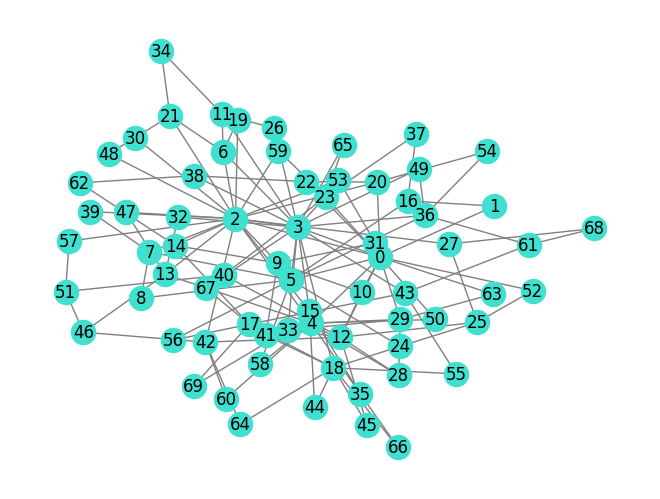

In [7]:
N = 70; # number of nodes
m = 2;
G = nx.barabasi_albert_graph(N,m,seed=None); # Barabasi-Albert graph

A = nx.adjacency_matrix(G).toarray(); # creates adjacency matrix

w = np.random.uniform(-2, 2, N); # defines natural frequencies
K = .5 # coupling constant
alpha = 1 # SL parameter

F = np.zeros(N)
for i in range(int(N/5)):
    F[5*i] = 1
Omega = np.pi

# initial conditions
theta0 = np.random.uniform(0, 2*np.pi, N)

nx.draw(G, node_color='turquoise', edge_color='grey', with_labels=True)
plt.show()


## The Kuramoto Model

The equations for a (forced) complex network of $N$ Kuramoto oscillators with natural frequencies $\omega_k$, adjacency matrix $A$, coupling strength (or average coupling strength, for the case where $A$ is weighted) $\lambda$ and a forced term of type $ F_i \cos{(\Omega t - \theta)} $ that acts on a fraction $f = N_F/N$, where $N_F$ is the number of forced oscillators (nonzero $F$), can be written as:

$$ \dot{\theta}_i = \omega_i + \lambda \sum_{j=1}^N A_{ij} \sin{(\theta_j - \theta_i)} + F_i \sin{(\Omega t - \theta_i)} $$

which gives the Jacobian:

$$ J_{ij} = \frac{\partial \dot{\theta}_i}{\partial \theta_j} = A_{ij} \cos{(\theta_j - \theta_i)} - \delta_{ij} F_i \cos{(\Omega t - \theta_i)} $$

If we measure the phase from a reference frame rotating with the forced frequency $\Omega$, i.e., make the change of variables $\phi_i = \theta_i - \Omega t$, we find:

$$ \dot{\phi}_i = \omega_i - \Omega + \lambda \sum_{j=1}^N A_{ij} \sin{(\phi_j - \phi_i)} - F_i \sin{(\phi_i)} $$

with Jacobian:

$$ J_{ij} = \frac{\partial \dot{\phi}_i}{\partial \phi_j} = A_{ij} \cos{(\phi_j - \phi_i)} - \delta_{ij} F_i \cos{(\phi_i)} $$

## 1. Simple Kuramoto

In [8]:
kuramoto = KuramotoNetwork(w, A, K)
Kforced = KuramotoNetwork(w, A, K, F, Omega)

In [9]:
%%time
t = np.arange(0,50,.2)
theta, _ = kuramoto.integrate(theta0, t)
theta_f, _ = Kforced.integrate(theta0, t)

CPU times: user 1min 20s, sys: 57.4 ms, total: 1min 20s
Wall time: 1min 22s


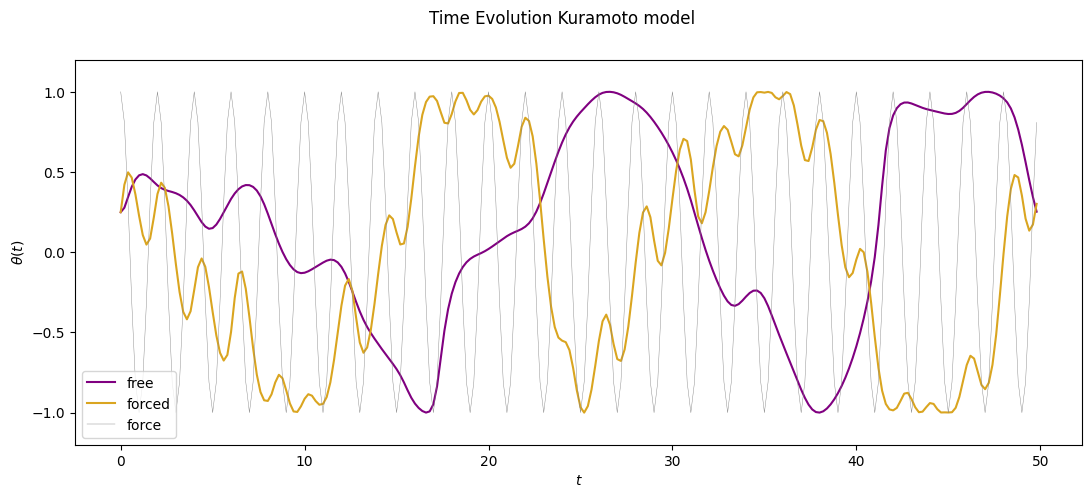

In [13]:
osc=5
fig, ax2 = plt.subplots(1,1, figsize=(13,5))

fig.suptitle('Time Evolution Kuramoto model')

#ax2.set_title('Kuramoto')
ax2.set_xlabel('$t$')
ax2.set_ylabel(r'$\theta(t)$')
ax2.set_ylim([-1.2, 1.2])

ax2.plot(t, np.cos(theta[i*osc]), label='free', color='purple')
ax2.plot(t, np.cos(theta_f[i*osc]), label='forced', color='goldenrod')
ax2.plot(t, F[osc]*np.cos(Omega*t), label='force', color='grey', linewidth='.3')
ax2.legend()

plt.show()

### Order Parameter

For a network of N oscillators with phase $\theta_i$, we can measure the system's synchronization with:

$$ \mathrm{z}(t) = r(t) e^{i \psi(t)} = \frac{1}{N} \sum_{j=1}^N e^{i \theta_j(t)} $$

The real part $r$ is called order parameter, whereas $\psi$ is the mean phase of the system. When the system is not synchronized, $r \approx 0$, whereas global synchronization is said to be achieved when $r \to 1$.

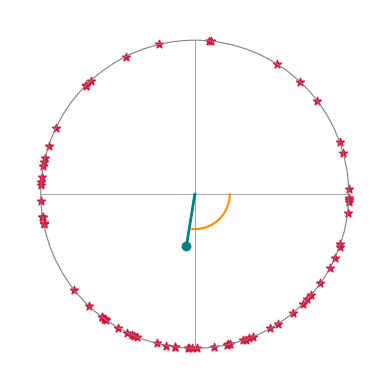

In [16]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')
ax.axis('off')

# Plots points corresponding to the oscillators' phase positions at time t
ax.scatter(np.cos(theta[:,200]), y = np.sin(theta[:,200]), marker = '*', color='crimson')

# Finds the order parameter at the time instant t
thetaT = np.transpose(theta)
order_par = sum(np.exp(thetaT[200]*1j))/N
r = np.absolute(order_par)
psi = np.angle(order_par)

# Plots horizontal and vertical diameters of the circle
ax.plot([-1, 1], [0, 0], linewidth = 0.5, color = 'grey')
ax.plot([0, 0], [-1, 1], linewidth = 0.5, color = 'grey')

#Plots unit circle
circle = plt.Circle((0,0), radius = 1.0, linewidth = 0.8, color = 'grey', fill = False)
ax.add_patch(circle)

#Plots order parameter line
ax.plot([0, r*np.cos(psi)], [0, r*np.sin(psi)], linewidth = 2.0, color = 'teal')
ax.scatter(r*np.cos(psi), r*np.sin(psi), marker='o', color='teal')

# Shows mean phase
s = np.arange(0,1,0.05)
if r>0.4:
    ax.plot(0.25*np.cos(psi*s), 0.25*np.sin(psi*s), color='darkorange')
else:
    ax.plot((2*r/3)*np.cos(psi*s), (2*r/3)*np.sin(psi*s), color='darkorange')

plt.show()

### Average in time

In practice, we actually calculate the mean value of $r$ and $psi$ (as well as their standard deviation) over a time interval $[t_0, t_0 + \Delta t]$ corresponding to at least one full oscillation period of the system so one can be sure our data is statistically relevant and time fluctuations are accounted for:

$$ \langle r \rangle = \frac{1}{\Delta t} \int_{t_0}^{t_0+\Delta t} r(t) dt $$

since we find the time evolution of the phase through numerical integration already, the integral above is performed as a Riemmann sum of the numerically obtained values. We also find it's useful to computate the angular velocity $\dot{\psi} = \frac{d \psi}{dt}$ of the mean phase, for it produces more insights on the colective dyamical behavior of the system.

We may then calculate such parameters for a range of different coupling constants $\lambda$ the  to see how the synchronization behavior is affected.

In [17]:
%%time
sync_par = OrderParameter(kuramoto, theta0, 40, 50, 0.1, Kf=3)

CPU times: user 17min 20s, sys: 703 ms, total: 17min 20s
Wall time: 17min 36s


In [18]:
K = sync_par['K']
r = sync_par['r']
r_std = sync_par['r_std']
psi = sync_par['psi']
psi_std = sync_par['psi_std']
psidot = sync_par['psidot']
psidot_std = sync_par['psidot_std']

/tmp/ipython-input-4039557416.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.errorbar(K ,r, yerr=r_std, marker='^', color = 'darkred', fmt='o', elinewidth=.5, \
/tmp/ipython-input-4039557416.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.errorbar(K ,psidot, yerr=psidot_std, marker='d', color = 'g', fmt='o', elinewidth=.5, \
/tmp/ipython-input-4039557416.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.errorbar(K ,psi/np.pi, yerr=psi_std, marker='x', color = 'indigo', fmt='o', \


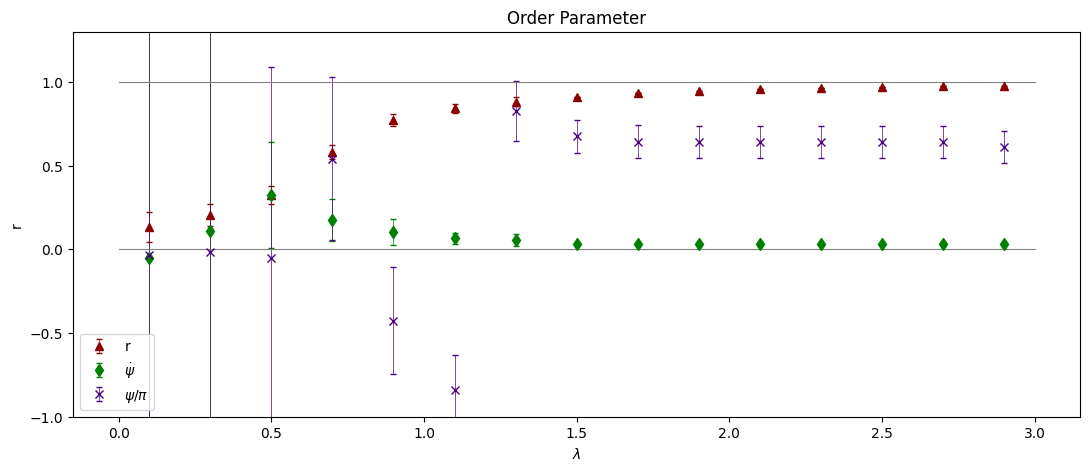

In [19]:
fig, ax1 = plt.subplots(1, 1, figsize=(13,5))

ax1.set_title("Order Parameter")
ax1.set_ylabel("r")
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylim(-1,1.3)

ax1.errorbar(K ,r, yerr=r_std, marker='^', color = 'darkred', fmt='o', elinewidth=.5, \
             capsize=2, label='r')
ax1.errorbar(K ,psidot, yerr=psidot_std, marker='d', color = 'g', fmt='o', elinewidth=.5, \
             capsize=2, label=r'$\dot{\psi}$')
ax1.errorbar(K ,psi/np.pi, yerr=psi_std, marker='x', color = 'indigo', fmt='o', \
             elinewidth=.5, capsize=2, label=r'$\psi / \pi$')

ax1.plot([0, 3], [1, 1], linewidth = .8, color = 'grey')
ax1.plot([0, 3], [0, 0], linewidth = .8, color = 'grey')

ax1.legend()
plt.show()

### Average in initial states

To assure statistical relevance, what may also be done is to find such parameters for a set with several different initial conditions and then take the average. This way, there can be certainty on the fact that the main dynamical properties of the systems indeed depends on the network itself, not relying on any specific initial configuration. We define the standard deviation $\sigma^{(r)}_{z_0}$ of $r$ in the initial conditions as:

$$ \sigma^{(r)}_{z_0} = \langle \ \langle r + \sigma^{(r)}_t \rangle_t + \langle r \rangle_t \ \rangle_{z0} $$

where $\langle \rangle_t$ is the time average, $\sigma^{(r)}_t$ the standard deviation with respect to time (both for a single initial condition $z_0$), and $\langle \rangle_{z_0}$ the average through all initial states $z_0$. It's worth to remark that we mantain $0.1 < \rho_0 < 0.9$ in the Stuart-Landau case, as for larger values of $\rho$ the system may fall into one of its attractors, which is not the situation we desire to analyze.

In [20]:
%%time
sync_par_av = AverageOrderPar(kuramoto, 3, 40, 45, .1, dt=0.2, Kf=2, dK=.2)

CPU times: user 21min 8s, sys: 770 ms, total: 21min 9s
Wall time: 21min 19s


In [21]:
K_av = sync_par_av['K']
r_av = sync_par_av['r']
r_std_av = sync_par_av['r_std']
psi_av = sync_par_av['psi']
psi_std_av = sync_par_av['psi_std']
psidot_av = sync_par_av['psidot']
psidot_std_av = sync_par_av['psidot_std']

/tmp/ipython-input-3866782125.py:8: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.errorbar(K_av ,r_av, yerr=r_std_av, marker='^', color = 'darkred', fmt='o', elinewidth=.5, \
/tmp/ipython-input-3866782125.py:10: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.errorbar(K_av ,psidot_av, yerr=psidot_std_av, marker='d', color = 'g', fmt='o', elinewidth=.5, \
/tmp/ipython-input-3866782125.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax1.errorbar(K_av ,psi_av/np.pi, yerr=psi_std_av, marker='x', color = 'indigo', fmt='o', \


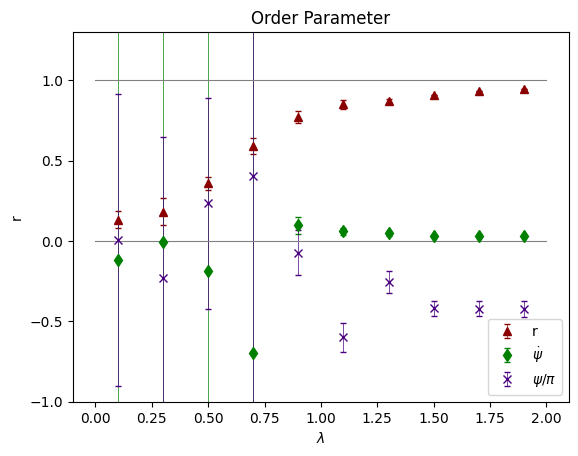

In [22]:
fig, ax1 = plt.subplots(1, 1)

ax1.set_title("Order Parameter")
ax1.set_ylabel("r")
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylim(-1,1.3)

ax1.errorbar(K_av ,r_av, yerr=r_std_av, marker='^', color = 'darkred', fmt='o', elinewidth=.5, \
             capsize=2, label='r')
ax1.errorbar(K_av ,psidot_av, yerr=psidot_std_av, marker='d', color = 'g', fmt='o', elinewidth=.5, \
             capsize=2, label=r'$\dot{\psi}$')
ax1.errorbar(K_av ,psi_av/np.pi, yerr=psi_std_av, marker='x', color = 'indigo', fmt='o', \
             elinewidth=.5, capsize=2, label=r'$\psi / \pi$')

ax1.plot([0, 2], [1, 1], linewidth = .8, color = 'grey')
ax1.plot([0, 2], [0, 0], linewidth = .8, color = 'grey')

ax1.legend()
plt.show()

## 2. Forced Kuramoto: rotating reference frame

In [ ]:
K = .5
kur_forced = KuramotoNetwork(w, A, K, F, Omega, rot_frame=True)

In [ ]:
%%time
t = np.arange(0,50,.2)
phi, _ = kur_forced.integrate(theta0, t)

CPU times: user 4.94 s, sys: 11.6 ms, total: 4.95 s
Wall time: 5.03 s


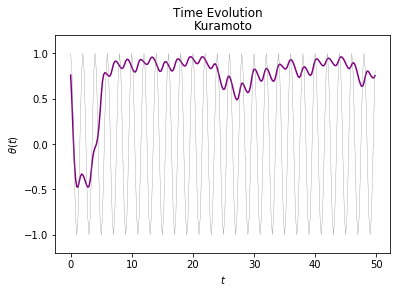

In [ ]:
osc=5
fig, ax2 = plt.subplots(1,1)

fig.suptitle('Time Evolution')

ax2.set_title('Kuramoto')
ax2.set_xlabel('$t$')
ax2.set_ylabel(r'$\theta(t)$')
ax2.set_ylim([-1.2, 1.2])

ax2.plot(t, np.cos(phi[osc]), color='purple')
ax2.plot(t, F[osc]*np.cos(Omega*t), color='grey', linewidth='.3')

plt.show()

### Order Parameter

$$ \mathrm{z}(t) = r(t) e^{i \psi(t)} = \frac{1}{N} \sum_{j=1}^N e^{i \theta_j(t)} $$

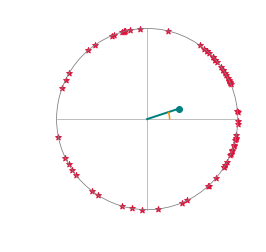

In [ ]:
fig = plt.figure()

ax = fig.add_subplot(111)

ax.set_xlim(-1.2, 1.2)
ax.set_ylim(-1.2, 1.2)
ax.set_aspect('equal')
ax.axis('off')

# Plots points corresponding to the oscillators' phase positions at time t
ax.scatter(np.cos(phi[:,200]), y = np.sin(phi[:,200]), marker = '*', color='crimson')

# Finds the order parameter at the time instant t
thetaT = np.transpose(phi)
order_par = sum(np.exp(thetaT[200]*1j))/N
r = np.absolute(order_par)
psi = np.angle(order_par)

# Plots horizontal and vertical diameters of the circle
ax.plot([-1, 1], [0, 0], linewidth = '.5', color = 'grey')
ax.plot([0, 0], [-1, 1], linewidth = '.5', color = 'grey')

#Plots unit circle
circle = plt.Circle((0,0), radius = 1.0, linewidth = '0.8', color = 'grey', fill = False)
ax.add_patch(circle)

#Plots order parameter line
ax.plot([0, r*np.cos(psi)], [0, r*np.sin(psi)], linewidth = '2.0', color = 'teal')
ax.scatter(r*np.cos(psi), r*np.sin(psi), marker='o', color='teal')

# Shows mean phase
s = np.arange(0,1,0.05)
if r>0.4:
    ax.plot(0.25*np.cos(psi*s), 0.25*np.sin(psi*s), color='darkorange')
else:
    ax.plot((2*r/3)*np.cos(psi*s), (2*r/3)*np.sin(psi*s), color='darkorange')

plt.show()

### Average in time

$$ \langle r \rangle = \frac{1}{\Delta t} \int_{t_0}^{t_0+\Delta t} r(t) dt $$

In [ ]:
%%time
sync_par = OrderParameter(kur_forced, theta0, 40, 45, 0.1, Kf=3)

CPU times: user 7min 37s, sys: 9.9 s, total: 7min 47s
Wall time: 5min 50s


In [ ]:
K = sync_par['K']
r = sync_par['r']
r_std = sync_par['r_std']
psi = sync_par['psi']
psi_std = sync_par['psi_std']
psidot = sync_par['psidot']
psidot_std = sync_par['psidot_std']

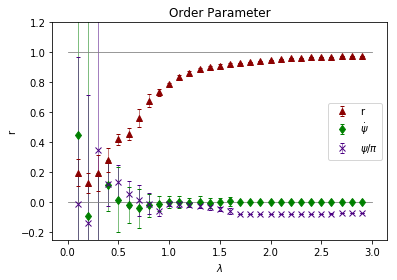

In [ ]:
fig, ax1 = plt.subplots(1, 1)

ax1.set_title("Order Parameter")
ax1.set_ylabel("r")
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylim(-.25,1.2)

ax1.errorbar(K ,r, yerr=r_std, marker='^', color = 'darkred', fmt='o', elinewidth=.5, \
             capsize=2, label='r')
ax1.errorbar(K ,psidot, yerr=psidot_std, marker='d', color = 'g', fmt='o', elinewidth=.5, \
             capsize=2, label=r'$\dot{\psi}$')
ax1.errorbar(K ,psi/np.pi, yerr=psi_std, marker='x', color = 'indigo', fmt='o', \
             elinewidth=.5, capsize=2, label=r'$\psi / \pi$')

ax1.plot([0, 3], [1, 1], linewidth = .8, color = 'grey')
ax1.plot([0, 3], [0, 0], linewidth = .8, color = 'grey')

ax1.legend()
plt.show()

### Average in initial states

$$ \sigma^{(r)}_{z_0} = \langle \ \langle r + \sigma^{(r)}_t \rangle_t + \langle r \rangle_t \ \rangle_{z0} $$

In [ ]:
%%time
sync_par_av = AverageOrderPar(kur_forced, 5, 40, 45, .1, dt=.2, Kf=2, dK=.2)

CPU times: user 7min 48s, sys: 5.27 s, total: 7min 53s
Wall time: 6min 59s


In [ ]:
K_av = sync_par_av['K']
r_av = sync_par_av['r']
r_std_av = sync_par_av['r_std']
psi_av = sync_par_av['psi']
psi_std_av = sync_par_av['psi_std']
psidot_av = sync_par_av['psidot']
psidot_std_av = sync_par_av['psidot_std']

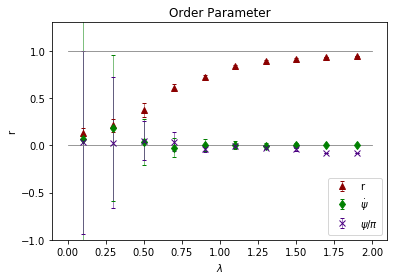

In [ ]:
fig, ax1 = plt.subplots(1, 1)

ax1.set_title("Order Parameter")
ax1.set_ylabel("r")
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylim(-1,1.3)

ax1.errorbar(K_av ,r_av, yerr=r_std_av, marker='^', color = 'darkred', fmt='o', elinewidth=.5, \
             capsize=2, label='r')
ax1.errorbar(K_av ,psidot_av, yerr=psidot_std_av, marker='d', color = 'g', fmt='o', elinewidth=.5, \
             capsize=2, label=r'$\dot{\psi}$')
ax1.errorbar(K_av ,psi_av/np.pi, yerr=psi_std_av, marker='x', color = 'indigo', fmt='o', \
             elinewidth=.5, capsize=2, label=r'$\psi / \pi$')

ax1.plot([0, 2], [1, 1], linewidth = .8, color = 'grey')
ax1.plot([0, 2], [0, 0], linewidth = .8, color = 'grey')

ax1.legend()
plt.show()